In [1]:
# Check GPU type
print("ça marche !")
!pip install nvidia-smi

# nvidia-smi est un outil en ligne de commande fourni par NVIDIA pour interagir avec les GPU NVIDIA installés sur un système.
# pas nécessaire pour kaggle car il gère l'accès aux ressources GPU

ça marche !


In [2]:
pip install --upgrade jupyter ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: jupyter-lsp
    Found existing installation: jupyter-lsp 1.5.1
    Uninstall

In [3]:
# Install ultralytics
!pip -q install  ultralytics

#ultralytics est une bibliothèque Python qui fournit des modèles de détection d'objets, de segmentation sémantique et d'autres tâches d'apprentissage profond.

In [4]:
# Import libraries
import pandas as pd                                                # Manipulation de données sous forme de tableaux
import os                                                          # Interactions avec le système d'exploitation
from pathlib import Path                                           # Manipulation de chemins de fichiers
import shutil                                                      # Opérations de copie et déplacement de fichiers
from sklearn.model_selection import train_test_split               # Division d'un jeu de données en ensembles d'entraînement et de test
from tqdm.notebook import tqdm                                     # Affichage de barres de progression dans un notebook Jupyter
import cv2                                                         # Traitement d'images
import yaml                                                        # Lecture et écriture de fichiers de configuration au format YAML
import matplotlib.pyplot as plt                                    # Création de visualisations
from ultralytics import YOLO                                       # Utilisation de modèles de détection d'objets
import multiprocessing                                             # Calculs en parallèle
from sklearn.model_selection import KFold
import subprocess
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Path to where your data is stored
DATA_DIR = Path('/kaggle/input/') # Définit le chemin vers le répertoire contenant les données

# Preview data files available
os.listdir(DATA_DIR) # Affiche la liste des fichiers disponibles dans le répertoire des données

['manifest-c922911ae9101743fc37dc64723c2ee220240829-19463-18lbi0k.json',
 'Lacuna_Malaria_Detection_Challenge_Starter.ipynb',
 'SampleSubmission.csv',
 'images',
 'Train.csv',
 'Test.csv']

In [6]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [7]:
# Unzip images to 'images' dir
if (DATA_DIR/ 'images.zip').exists():
    shutil.unpack_archive(DATASET_DIR / 'images.zip', 'IMAGES_DIR')  # Dézippe le fichier 'images.zip' vers le répertoire 'IMAGES_DIR'
else:
    print("fichier déjà dézippé")             # Si le fichier est déjà dézippé, affiche un message informant que le fichier est déjà extrait

fichier déjà dézippé


In [8]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')          # Charge le fichier CSV contenant les données d'entraînement
test = pd.read_csv(DATA_DIR / 'Test.csv')            # Charge le fichier CSV contenant les données de test
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')  # Charge le fichier CSV contenant un exemple de soumission

# Add an image_path column
train['image_path'] = [Path('../input/images/' + x) for x in train.Image_ID]   # Ajoute une colonne 'image_path' avec le chemin des images d'entraînement
test['image_path'] = [Path('../input/images/' + x) for x in test.Image_ID]    # Ajoute une colonne 'image_path' avec le chemin des images de test

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2}) # Encode les classes sous forme d'entiers (0, 1, 2)

# Preview the head of the train set
train.head()            # Affiche les premières lignes du jeu de données d'entraînement

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,../input/images/id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,../input/images/id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,../input/images/id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,../input/images/id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,../input/images/id_6dop09rk02.jpg,2


In [9]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
# Yolo reccomends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)       # Filtre le jeu de données d'entraînement pour ne garder que les images 
                                                                         # qui ne sont pas de classe 'NEG' (négatif), 
                                                                        # puis réinitialise l'index des lignes

In [10]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True) # Crée un DataFrame contenant les images d'entraînement uniques
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42) # Divise les images d'entraînement uniques en ensembles d'entraînement et de validation, 
                                                                                                                                   # en respectant la stratification des classes et en utilisant un seed aléatoire

# Cette syntaxe est utilisée pour le filtrage en pandas. 
# Elle sélectionne toutes les lignes du DataFrame train où le masque booléen est True.    
X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((17354, 9), (5488, 9))

In [11]:
X_train.head()
X_val.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,../input/images/id_a6cl90trri.jpg,0
6,id_i8qcpi8ey9.jpg,Trophozoite,1.0,501,1141,532,1170,../input/images/id_i8qcpi8ey9.jpg,0
9,id_i4d0ulpq39.jpg,WBC,1.0,799,838,863,906,../input/images/id_i4d0ulpq39.jpg,1
11,id_8y0uii4k60.jpg,Trophozoite,1.0,1950,2315,2077,2410,../input/images/id_8y0uii4k60.jpg,0
16,id_ytq3slqkjm.jpg,Trophozoite,1.0,108,768,148,800,../input/images/id_ytq3slqkjm.jpg,0


In [12]:
# Preview target distribution, seems there a class imbalance that needs to be handled
# Affiche la répartition en pourcentage des classes dans les jeux de données d'entraînement et de validation
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.688141
 WBC            0.311859
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.709913
 WBC            0.290087
 Name: proportion, dtype: float64)

In [13]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)   # Si le répertoire existe, le supprime de manière récursive
  DIR.mkdir(parents=True, exist_ok = True)   # Crée le répertoire s'il n'existe pas, avec création des répertoires parents si nécessaire

In [14]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
    shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1]) # Copie chaque image unique du jeu d'entraînement dans le répertoire TRAIN_IMAGES_DIR

for img in tqdm(X_val.image_path.unique()):
    shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1]) # Copie chaque image unique du jeu de validation dans le répertoire VAL_IMAGES_DIR

for img in tqdm(test.image_path.unique()):
    shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1]) # Copie chaque image unique du jeu de test dans le répertoire TEST_IMAGES_DIR

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [15]:
# Function to convert the bboxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")  # Vérifie si l'image peut être lue

    height, width, _ = img.shape  # Récupère les dimensions de l'image

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"  # Définit le chemin du fichier de labels

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']


    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width           # Calculer le centre x normalisé
    y_center = (ymin + ymax) / 2 / height          # Calculer le centre y normalisé
    bbox_width = (xmax - xmin) / width             # Calculer la largeur normalisée
    bbox_height = (ymax - ymin) / height           # Calculer la hauteur normalisée

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir # Ajoute une colonne 'output_dir' au DataFrame
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe))) # Exécute la fonction save_yolo_annotation en parallèle pour chaque ligne du DataFrame

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)      # Sauvegarde les labels d'entraînement dans le répertoire TRAIN_LABELS_DIR
process_dataset(X_val, VAL_LABELS_DIR)          # Sauvegarde les labels de validation dans le répertoire VAL_LABELS_DIR

/tmp/ipykernel_30/2835044223.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir # Ajoute une colonne 'output_dir' au DataFrame


  0%|          | 0/17354 [00:00<?, ?it/s]

/tmp/ipykernel_30/2835044223.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir # Ajoute une colonne 'output_dir' au DataFrame


  0%|          | 0/5488 [00:00<?, ?it/s]

In [16]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [17]:
# Create a data.yaml file required by yolo
class_names = train['class'].unique().tolist()  # Récupère la liste des noms de classes uniques dans le jeu de données d'entraînement
num_classes = len(class_names)                  # Calcule le nombre de classes

data_yaml = {
    # getcwd() est une fonction qui retourne une chaîne de caractères représentant le chemin absolu du répertoire de travail actuel
    'train': os.getcwd()+'/' + str(TRAIN_IMAGES_DIR),    # Définit le chemin du répertoire des images d'entraînement
    'val': os.getcwd()+'/' + str(VAL_IMAGES_DIR),        # Définit le chemin du répertoire des images de validation
    'test': os.getcwd()+'/' + str(TEST_IMAGES_DIR),      # Définit le chemin du répertoire des images de test
    'nc': num_classes,                                   # Définit le nombre de classes
    'names': class_names                                 # Définit la liste des noms de classes
}

data1_yaml = {
    # getcwd() est une fonction qui retourne une chaîne de caractères représentant le chemin absolu du répertoire de travail actuel
    'train': os.getcwd()+'/' + str(TRAIN_IMAGES_DIR),    # Définit le chemin du répertoire des images d'entraînement
    'val': os.getcwd()+'/' + str(VAL_IMAGES_DIR),        # Définit le chemin du répertoire des images de validation
    'test': os.getcwd()+'/' + str(TEST_IMAGES_DIR),      # Définit le chemin du répertoire des images de test
    'nc': num_classes,                                   # Définit le nombre de classes
    'names': class_names                                 # Définit la liste des noms de classes
}

yaml_path = 'data.yaml'                            # Définit le chemin du fichier YAML à créer
yaml1_path = 'data1.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)            # Écrit le dictionnaire data_yaml dans le fichier YAML

with open(yaml1_path, 'w') as file:
    yaml.dump(data1_yaml, file, default_flow_style=False)     
    
# Preview data yaml file
data_yaml                                             # Affiche le contenu du fichier YAML créé
data1_yaml

{'train': '/kaggle/working/datasets/dataset/images/train',
 'val': '/kaggle/working/datasets/dataset/images/val',
 'test': '/kaggle/working/datasets/dataset/images/test',
 'nc': 2,
 'names': ['Trophozoite', 'WBC']}

Plotting id_8fthc0keoz.jpg with 9 bounding boxes.


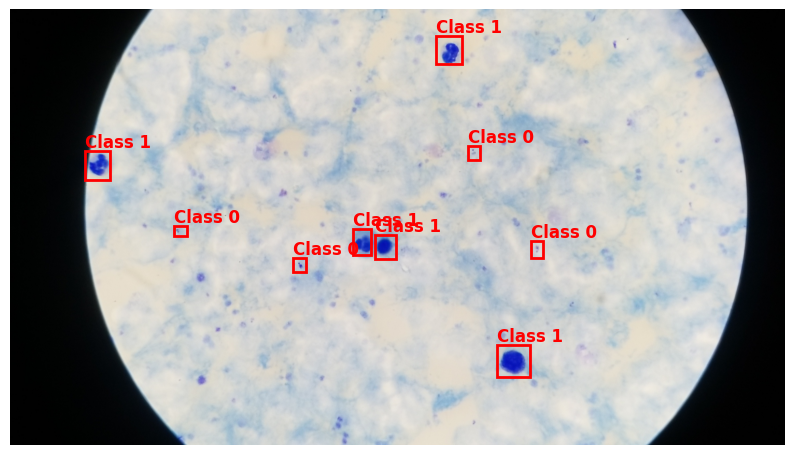

Plotting id_ru4hal0k5c.jpg with 7 bounding boxes.


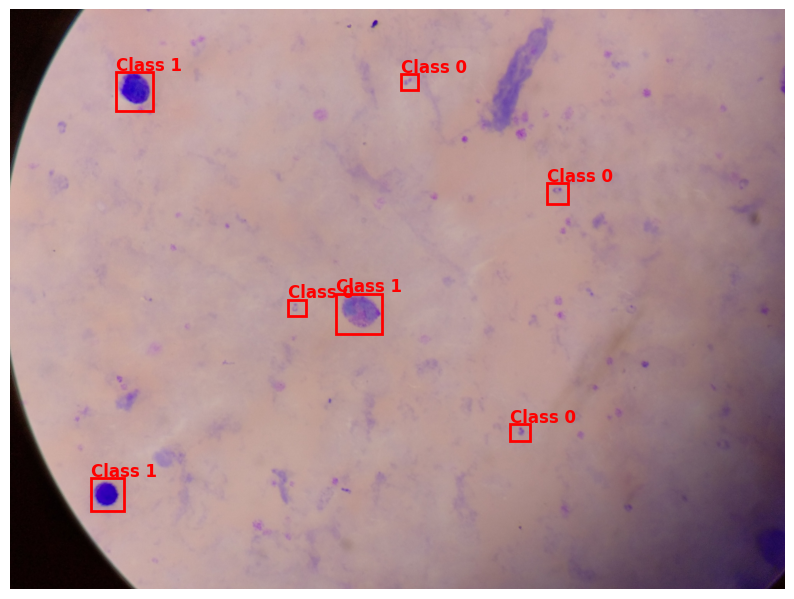

Plotting id_u5cxqsylou.jpg with 8 bounding boxes.


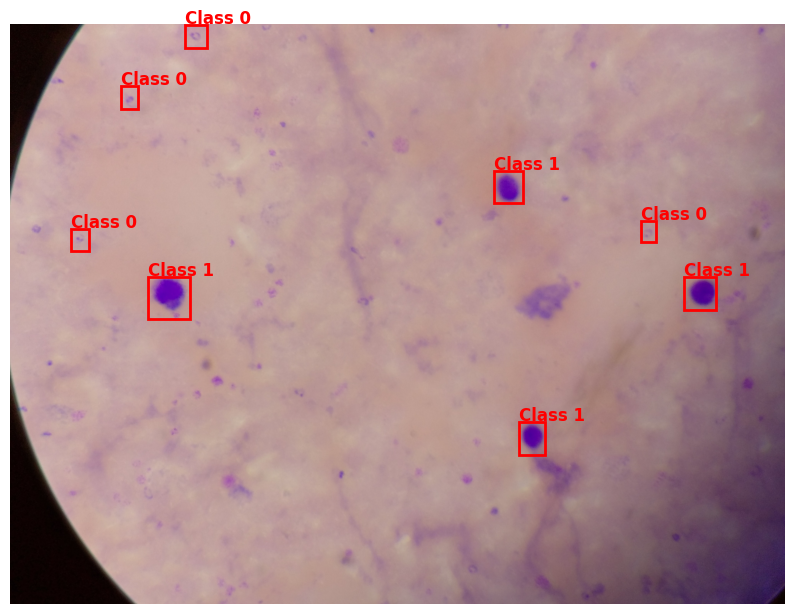

In [18]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()  # Lit toutes les lignes du fichier de labels
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())  # Convertit les informations de chaque ligne en coordonnées numériques
        boxes.append((class_id, x_center, y_center, width, height))  # Ajoute les coordonnées de la boîte englobante à la liste
    return boxes  # Retourne la liste des boîtes englobantes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))  # Charge l'image depuis le chemin spécifié
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR au format RGB

    # Get image dimensions
    h, w, _ = image.shape  # Récupère les dimensions de l'image

    # Plot the image
    plt.figure(figsize=(10, 10))  # Définit la taille de la figure pour l'affichage
    plt.imshow(image)  # Affiche l'image

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box  # Récupère les propriétés de la boîte englobante
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)  # Calcule la coordonnée x minimale
        ymin = int((y_center - height / 2) * h)  # Calcule la coordonnée y minimale
        xmax = int((x_center + width / 2) * w)  # Calcule la coordonnée x maximale
        ymax = int((y_center + height / 2) * h)  # Calcule la coordonnée y maximale

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))  # Dessine la boîte englobante
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')  # Affiche le texte de la classe au-dessus de la boîte englobante

    plt.axis('off')  # Désactive les axes
    plt.show()  # Affiche le résultat

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR  # Définit le répertoire des images d'entraînement
LABEL_DIR = TRAIN_LABELS_DIR  # Définit le répertoire des labels d'entraînement

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:          # Parcourt les trois premières images du répertoire d'images
    image_path = IMAGE_DIR / image_name               # Crée le chemin de l'image
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))    # Crée le chemin du fichier de labels correspondant

    if label_path.exists():                           # Vérifie si le fichier de labels existe
        boxes = load_annotations(label_path)          # Charge les annotations à partir du fichier de labels
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")      # Affiche le nom de l'image et le nombre de boîtes englobantes
        plot_image_with_boxes(image_path, boxes)      # Affiche l'image avec ses boîtes englobantes
    else:
        print(f"No annotations found for {image_name}.")                       # Informe qu'aucune annotation n'a été trouvée pour l'image

In [ ]:

# Load a yolo pretrained model
os.environ['ULTRALYTICS_DDP_LAUNCH'] = 'torch.distributed.launch'

os.environ['NCCL_P2P_DISABLE'] = '1'

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("API_key_YOLO")
os.environ['WANDB_API_KEY'] = secret_value_0

# model = YOLO('yolov8m.pt')  # Charge un modèle YOLO pré-entraîné à partir du fichier 'yolov8m.pt'
# model1 = YOLO("yolo11n.pt")  # Charge un modèle YOLO pré-entraîné à partir du fichier 'yolov11n.pt'
# model = YOLO('yolov10n.pt')  # Charge un modèle YOLO pré-entraîné nano versiion à partir du fichier 'yolov11n.pt'
# model = YOLO('yolov10x.pt')  # YOLOv10-X extra-large version
model = YOLO('yolov5su.pt')  # YOLOv5 small version


# Charger les chemins du fichier data.yaml
data_path = '/kaggle/working/data.yaml'
# Lire le fichier data.yaml pour obtenir les chemins du jeu de données
with open(data_path, 'r') as file:
    data = yaml.safe_load(file)

# Chemin vers les images d'entraînement dans le fichier yaml
image_dir = data['train']  # Chemin vers les images d'entraînement dans data.yaml

# Charger toutes les images (tu peux adapter selon ton format)
image_paths = np.array([f"{image_dir}/{img}" for img in os.listdir(image_dir)])

# Fine tune model to our data
# Paramètres de la validation croisée
n_splits = 20  # Nombre de folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Stocker les résultats des folds
fold_results = []

# Effectuer la validation croisée
for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"Fold {fold+1}/{n_splits}")
    
    # Créer les jeux d'entraînement et de validation pour ce fold
    train_images = image_paths[train_idx]
    val_images = image_paths[val_idx]
    
    # Entraîner le modèle
    model.train(
        data=data_path,         # Chemin vers les annotations yaml
        epochs=30,              # Nombre d'époques
        imgsz=640,              # Taille des images
        batch=16,               # Taille du lot
        device=0,               # Utilisation du GPU
        lr0=0.001,              # Taux d'apprentissage
        weight_decay=0.0005,    # Décroissance du poids
        momentum=0.937,         # Momentum
        patience=20,            # Early stopping
        mixup=0.2,              # Data augmentation
        #evolve=50 # Nombre de générations pour l'évolution des hyperparamètres
    )
    
    
    # Valider le modèle après l'entraînement
    results = model.val(data=data_path)

    # Extraire le mAP pour ce fold
    # Utilisation de results_dict pour accéder aux métriques
    
    fold_mAP = results.box.map  # mAP@0.5
    print(f"Fold {fold+1} mAP@0.5: {fold_mAP}")
    
    # Ajouter le mAP de ce fold aux résultats
    fold_results.append(fold_mAP)

# Calculer la performance moyenne sur tous les folds
mean_performance = np.mean(fold_results)
print(f"Moyenne des performances mAP@0.5 sur tous les folds: {mean_performance}")

# # Évaluer le modèle sur ce fold
# results = model.val(data=data_path)
    
# # Ajouter les résultats de ce fold (par exemple le mAP)
# fold_results.append(results['metrics/mAP_0.5'])  # Adapter selon la métrique d'évaluation souhaitée

# # Calculer la performance moyenne sur tous les folds
# mean_performance = np.mean(fold_results)
# print(f"Performance moyenne sur {n_splits} folds: {mean_performance}")

# Ainsi, le modèle utilisera les hyperparamètres définis dans hyp.scratch-low.yaml pour l'entraînement. Cela est utile 
# pour ajuster automatiquement le comportement d'entraînement du modèle sans avoir à les spécifier tous manuellement.

# model.train(
#     data='/kaggle/working/data.yaml',
#     epochs=60,
#     imgsz=640,              # Augmentation de la taille des images
#     batch=8,                # Augmentation de la taille du lot
#     device=[0,1],           # Utilisation des deux GPU
#     lr0=0.001,               # Taux d'apprentissage initial réduit
#     lrf=0.1,                 # Réduction finale du taux d'apprentissage
#     weight_decay=0.001,      # Décroissance du poids augmentée
#     momentum=0.937,          # Momentum inchangé
#     patience=15,             # Arrêt anticipé plus rapide
#     mixup=0.2,               # Gardez mixup
#     mosaic=1.0,              # Activez mosaïque
#     auto_augment='randaugment',  # Augmentation automatique
#     hsv_s=0.8,               # Saturation augmentée
#     hsv_v=0.6,               # Valeur augmentée
#     erasing=0.5,             # Augmentation du masquage aléatoire
#     dropout=0.3,             # Dropout pour éviter le surapprentissage
#     multi_scale=True,        # Entraînement à plusieurs échelles
#     iou=0.5,                 # Seuil IoU réduit
#     conf=0.001,              # Seuil de confiance très bas
#     warmup_epochs=5,         # Période de warmup prolongée
#     warmup_momentum=0.9,     # Momentum augmenté pendant le warmup
#     optimizer='SGD',         # Changer l'optimiseur à SGD
# )


#     model.train(
#     data='/kaggle/working/data.yaml',          # Chemin vers le fichier de configuration du jeu de données
#     epochs=50,                 # Nombre d'époques pour l'entraînement
#     imgsz=640,                # Taille des images (hauteur, largeur) pour l'entraînement
#     batch=16,                   # Taille du lot (nombre d'images traitées simultanément)
#     device=0,                  # Dispositif à utiliser (0 pour le premier GPU)
#     patience=25)                # Nombre d'époques sans amélioration avant d'arrêter l'entraînement



# model.train(
#     data='/kaggle/working/data.yaml',  # Chemin vers le jeu de données
#     epochs=60,                        # Nombre d'époques
#     imgsz=640,                        # Taille des images
#     batch=16,                          # Taille du lot
#     device=[0,1], 
#     lr0=0.001,                          # Taux d'apprentissage initial
#     weight_decay=0.0005,               # Décroissance du poids
#     momentum=0.937,                    # Momentum     
#     patience=20,                       # Early stopping après 20 époques sans amélioration
#     mixup=0.2,                         # Mixup pour augmenter les données                        # CutMix pour augmenter les données
# )



# model.train(
#     data='data.yaml',          # Chemin vers le fichier de configuration du jeu de données
#     epochs=15,                 # Nombre d'époques pour l'entraînement
#     imgsz=1024,                # Taille des images (hauteur, largeur) pour l'entraînement
#     batch=4,                   # Taille du lot (nombre d'images traitées simultanément)
#     device=0,                  # Dispositif à utiliser (0 pour le premier GPU)
#     patience=5)                # Nombre d'époques sans amélioration avant d'arrêter l'entraînement

# model1.train(                   # modèle d'entraînement version 11
#     data='data1.yaml',          # Chemin vers le fichier de configuration du jeu de données
#     epochs=15,                 # Nombre d'époques pour l'entraînement
#     imgsz=1024,                # Taille des images (hauteur, largeur) pour l'entraînement
#     batch=4,                   # Taille du lot (nombre d'images traitées simultanément)
#     device=0,                  # Dispositif à utiliser (0 pour le premier GPU)
#     patience=5)                # Nombre d'époques sans amélioration avant d'arrêter l'entraînement


# API key YOLO: 16f98b448b32978776227e1dc1393980cbb45166

In [ ]:
#Vérification de l'installation de pytorch
import torch
import torch.nn as nn
print(torch.__version__)
print(torch.version.cuda)

In [ ]:
# Validate the model on the validation set
model = YOLO('/' + os.getcwd() + '/runs/detect/train/weights/best.pt')  # Charge le modèle YOLO à partir du fichier 'best.pt' qui contient les poids du meilleur modèle entraîné
results = model.val()                                                   # Évalue le modèle sur le jeu de validation et stocke les résultats de la validation

In [ ]:
import os
import pandas as pd
from sklearn.svm import SVC
from tqdm import tqdm
from ultralytics import YOLO

# Charger le modèle YOLO entraîné
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Initialiser un modèle SVM pour la classification


# Load the trained YOLO model
model = YOLO('/'+os.getcwd()+'/runs/detect/train/weights/best.pt')

# Path to the test images directory
test_dir_path = '/'+os.getcwd()+'/datasets/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)  # Récupère la liste de tous les fichiers image dans le répertoire de test

# Initialize an empty list to store the results for all images
all_data = []  # Initialise une liste vide pour stocker les résultats de toutes les images

# Iterate through each image in the directory
for image_file in tqdm(image_files):  # Parcourt chaque fichier image dans le répertoire, avec une barre de progression
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)  # Crée le chemin complet vers l'image

    # Make predictions on the image
    results = model(img_path)  # Effectue des predictions sur l'image à l'aide du modèle

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Récupère les boîtes englobantes au format xyxy
    classes = results[0].boxes.cls.tolist()  # Récupère les indices de classe
    confidences = results[0].boxes.conf.tolist()  # Récupère les scores de confiance
    names = results[0].names  # Récupère le dictionnaire des noms de classe

    if not boxes:  # Vérifie s'il n'y a pas de détections
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,  # ID de l'image
            'class': 'NEG',           # Classe par défaut 'NEG' (négatif)
            'confidence': 1.0,        # Valeur par défaut (vous pouvez la définir comme valeur standard)
            'ymin': 0,                # Valeur par défaut (pas de détection)
            'xmin': 0,                # Valeur par défaut (pas de détection)
            'ymax': 0,                # Valeur par défaut (pas de détection)
            'xmax': 0                 # Valeur par défaut (pas de détection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):  # Parcourt les résultats de cette image
            x1, y1, x2, y2 = box  # Récupère les coordonnées de la boîte englobante
            detected_class = names[int(cls)]  # Récupère le nom de la classe à partir du dictionnaire de noms

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,  # ID de l'image
                'class': detected_class,  # Classe détectée
                'confidence': conf,       # Score de confiance
                'ymin': y1,               # Coordonnée y minimale
                'xmin': x1,               # Coordonnée x minimale
                'ymax': y2,               # Coordonnée y maximale
                'xmax': x2                # Coordonnée x maximale
            })
# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

In [ ]:
sub.head()  # Affiche les premières lignes du DataFrame 'sub' pour donner un aperçu de son contenu

In [ ]:
sub['class'].value_counts()  # Affiche le nombre d'occurrences de chaque classe dans la colonne 'class' du DataFrame 'sub'

In [ ]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_submission.csv', index = False)